In [22]:
! pip install -U qiskit
! pip install -U pylatexenc
! pip install -U qiskit_algorithms
! pip install -U qiskit_machine_learning

In [23]:
# Import necessary libraries
import numpy as np
np.random.seed(1106)

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from IPython.display import clear_output

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes, PauliFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, NFT
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

# Exercise 1
This notebook will focus on Quantum Neural Networks. QNNs encompass a wide variety of QML models, but we will only look at the basic version of them in this tutorial.

In [24]:
#@title Predefined functions
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
  clear_output(wait=True)
  objective_func_vals.append(obj_func_eval)
  plt.xlabel("Iteration")
  plt.ylabel("Objective function value")
  plt.plot(range(len(objective_func_vals)), objective_func_vals)
  plt.show()

def plot_decision_boundary(X_train, X_test, y_train, y_test, classifier):
  feature_1, feature_2 = np.meshgrid(
        np.linspace(X[:, 0].min()-0.5, X[:, 0].max()+0.5),
        np.linspace(X[:, 1].min()-0.5, X[:, 1].max()+0.5)
    )
  grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
  y_predict = classifier.predict(grid)
  y_pred = np.reshape(y_predict, feature_1.shape)
  display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)
  display.plot(alpha=0.4)
  plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', edgecolor='k', cmap='viridis')
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='^', edgecolor='k', cmap='viridis')
  train_handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=10, label='Train')
  test_handle = plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='k', markersize=10, label='Test')
  plt.legend(handles=[train_handle, test_handle], title='Dataset', bbox_to_anchor=(1, 1))
  plt.xlabel("Feature 1")
  plt.ylabel("Feature 2")
  plt.show()

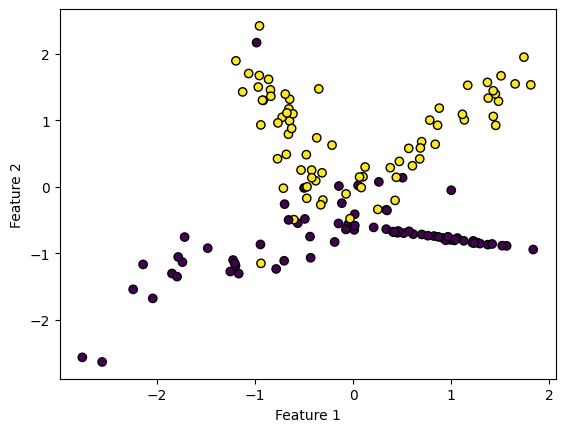

In [25]:
# Same dataset as in the first notebook
X, y = make_classification(n_samples=150, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=1106)
y = np.array([-1 if i == 0 or i == -1 else 1 for i in y]) # the following works better with -1 and 1 as classes instead of 0 and 1
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1106)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

You want to learn this dataset using QNNs. So the first question has to be, how do you want to encode the features into quantum states? You start simple by encoding one feature into one qubit with an Rz rotation.

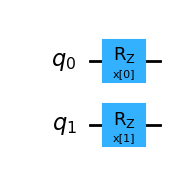

In [26]:
FEATURE_DIMENSION = 2
NUM_QUBITS = 2

# Qiskit feature maps should generally be QuantumCircuits or extensions of QuantumCircuit
feature_map = QuantumCircuit(NUM_QUBITS)
user_params = ParameterVector("x", NUM_QUBITS)

# Create circuit layer with trainable parameters
for i in range(NUM_QUBITS):
    feature_map.rz(user_params[i], i)

feature_map.draw('mpl')

For the ansatz you want tomething hardware-efficient so you go with Ry rotations ans cnot gates

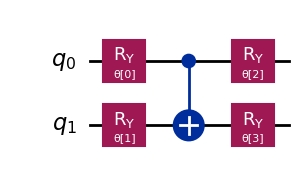

In [27]:
ansatz = RealAmplitudes(NUM_QUBITS, entanglement='linear', reps=1)
ansatz.decompose().draw(output='mpl')

Combine them to create a QNNCircuit

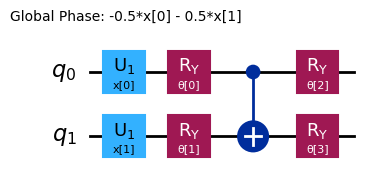

In [28]:
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)
estimator_qnn = EstimatorQNN(circuit=qc)
qc.decompose().draw("mpl")

And optimize

In [29]:
optimizer = COBYLA(maxiter=20) #other optimizer you can test: NFT(maxfev=200) #SPSA(maxiter=50) #L_BFGS_B(maxiter = 10)
loss = 'squared_error' # other loss functions you can test: 'cross_entropy'
classifier = NeuralNetworkClassifier(estimator_qnn, optimizer=optimizer, callback=callback_graph, loss=loss)

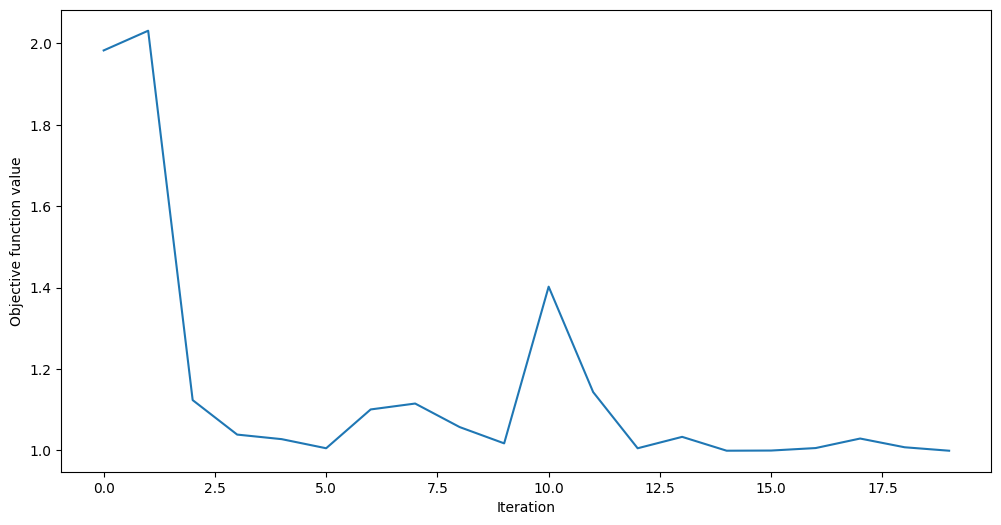

Accuracy on training set:  0.5142857142857142
Optimized weights:  [0.38871562 2.3007889  1.16968887 1.13368414]


In [30]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(X_train, y_train)
# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

print("Accuracy on training set: ", classifier.score(X_train, y_train))
print("Optimized weights: ", classifier.weights)

The test accuracy of your model is  0.4888888888888889


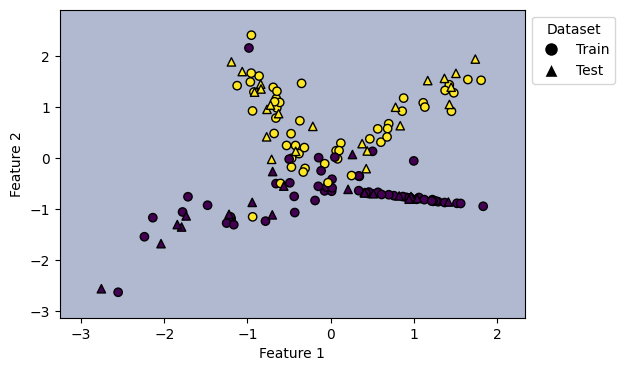

In [31]:
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print('The test accuracy of your model is ', accuracy)
plot_decision_boundary(X_train, X_test, y_train, y_test, classifier)

Something does not seem to be working, figure out the issue with this model and fix it

In [ ]:
#@title Solution
# In qiskit a the initial sate is the |0> state. Applying Rz rotation cannot change this state (it will only add a global phase).
# There are many ways to fix it, like making Ry rotations instead of Rz, add random rotations in the beginning to start from a Haar random state, or start from |+> by inserting a hadamard gate before the rotation

feature_map = QuantumCircuit(NUM_QUBITS)
user_params = ParameterVector("x", NUM_QUBITS)
for i in range(NUM_QUBITS):
    #feature_map.h(i)
    feature_map.ry(user_params[i], i)
feature_map.draw('mpl')

#repeat the above
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)
estimator_qnn = EstimatorQNN(circuit=qc)
optimizer = COBYLA(maxiter=20) #other optimizer you can test: NFT(maxfev=200) #SPSA(maxiter=50) #L_BFGS_B(maxiter = 10)
loss = 'squared_error' # other loss functions you can test: 'cross_entropy'
classifier = NeuralNetworkClassifier(estimator_qnn, optimizer=optimizer, callback=callback_graph, loss=loss)
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(X_train, y_train)
# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

print("Accuracy on training set: ", classifier.score(X_train, y_train))
print("Optimized weights: ", classifier.weights)

y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print('The test accuracy of your model is ', accuracy)
plot_decision_boundary(X_train, X_test, y_train, y_test, classifier)

#Exercise 2
Is entanglement improving this embedding? try to make one simple layer of Ry rotations as ansatz test again
Hint: you will need to make a custom ansatz like the custom embedding above. You can write latex code in python like `r"$\theta$"` to give the parameters the correct name.

In [ ]:
#@title Solution
ansatz = QuantumCircuit(NUM_QUBITS)
user_params = ParameterVector(r"$\theta$", NUM_QUBITS)
for i in range(NUM_QUBITS):
    ansatz.ry(user_params[i], i)
ansatz.draw('mpl')

#repeat the above
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)
estimator_qnn = EstimatorQNN(circuit=qc)
optimizer = COBYLA(maxiter=20) #other optimizer you can test: NFT(maxfev=200) #SPSA(maxiter=50) #L_BFGS_B(maxiter = 10)
loss = 'squared_error' # other loss functions you can test: 'cross_entropy'
classifier = NeuralNetworkClassifier(estimator_qnn, optimizer=optimizer, callback=callback_graph, loss=loss)
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(X_train, y_train)
# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

print("Accuracy on training set: ", classifier.score(X_train, y_train))
print("Optimized weights: ", classifier.weights)

y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print('The test accuracy of your model is ', accuracy)
plot_decision_boundary(X_train, X_test, y_train, y_test, classifier)

#Exercise 3
In the above case the ansatz with entanglement actually performed better. However, it was also an unfair comparison becuase it had 4 parameters and the one without entanglement just 2. Make the comparison faierer and make an ansatz that has for each qubit a Rx rotation followed by an Ry rotation. What do you observe now?

In [ ]:
#@title Solution
ansatz = QuantumCircuit(NUM_QUBITS)
user_params = ParameterVector(r"$\theta$", 4)
for i in range(NUM_QUBITS):
    ansatz.rx(user_params[2*i], i)
    ansatz.ry(user_params[2*i+1], i)
ansatz.draw('mpl')

#repeat the above
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)
estimator_qnn = EstimatorQNN(circuit=qc)
optimizer = COBYLA(maxiter=20) #other optimizer you can test: NFT(maxfev=200) #SPSA(maxiter=50) #L_BFGS_B(maxiter = 10)
loss = 'squared_error' # other loss functions you can test: 'cross_entropy'
classifier = NeuralNetworkClassifier(estimator_qnn, optimizer=optimizer, callback=callback_graph, loss=loss)
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(X_train, y_train)
# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

print("Accuracy on training set: ", classifier.score(X_train, y_train))
print("Optimized weights: ", classifier.weights)

y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print('The test accuracy of your model is ', accuracy)
plot_decision_boundary(X_train, X_test, y_train, y_test, classifier)

The final verdict of entanglement is now useful or not in this classification task it left open. As a final remark, in qiskit there are also predefined feature maps so you don't have to make a custom one. For instance te general PauliFeatureMap or the specific ZZFeatureMap

